#### Autoencoder

In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader,TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 123
learning_rate = 0.005
num_epochs = 5
batch_size = 256

# Architecture
num_features = 784
num_hidden_1 = 100

Device: cuda:0


In [2]:
# Load data
images = np.load("F:/Fall 2019/stat 479-ML/Project_Group_7/GITHUB/sample_1000_image.npy")
labels = np.load("F:/Fall 2019/stat 479-ML/Project_Group_7/GITHUB/sample_1000_label.npy")

# Normalize image data.  0-255 to 0-1
images = images / 255
df = pd.DataFrame(np.concatenate((images, labels), axis=1))

# Rename the last column as "label"
df.rename(columns={784:"label"}, inplace=True)

# Convert label column to integer type
df['label'] = df['label'].astype('int64')

In [78]:
all_=np.load("F:/Fall 2019/stat 479-ML/Project_Group_7/GITHUB/sample_1000.npy",allow_pickle=True)

In [79]:
print(all_[5])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 18 19 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 202 216 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 72
 255 255 89 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 184 233 234
 151 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 172 255 249 217 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 164 235 231 198 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 226 178 218 162 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 29 249 255 253 223 156 104 75 68 64 81 108 131 159
 165 133 99 64 30 2 0 0 0 0 0 0 0 0 99 255 127 124 176 228 255 255 255 255
 255 255 246 220 212 246 255 255 255 248 215 181 146 77 0 0 0 0 100 255 22
 3 27 0 22 50 51 63 41 15 0 0 0 0 26 60 95 129 164 199 235 254 58 0 0 0
 100 255 22 92 242 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 15 254 112 0 0 0 100
 255 22 7 43 0 0 0 0 0 0 0 0 0 0 0 0 0

In [3]:
img = df.iloc[:, 0:-1]
lbl = df['label']

#Split dataset
x_train1, x_test, y_train1, y_test = train_test_split(img, lbl, test_size = 0.20, random_state = 123, stratify = lbl)
print(x_train1.shape)
print(y_train1.shape)
print(x_test.shape)

(276000, 784)
(276000,)
(69000, 784)


In [4]:
#Convert dataframe to tensor
x_train1 = torch.tensor(x_train1.values)
y_train1 = torch.tensor(y_train1.values)

x_test = torch.tensor(x_test.values)
y_test = torch.tensor(y_test.values)

In [5]:
#Create dataloaders
train_dataset = TensorDataset(x_train1, y_train1)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

In [6]:
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([256, 784])
Image label dimensions: torch.Size([256])


In [7]:
##########################
### MODEL
##########################

class Autoencoder(torch.nn.Module):

    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        
        ### ENCODER
        
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        # The following to lones are not necessary, 
        # but used here to demonstrate how to access the weights
        # and use a different weight initialization.
        # By default, PyTorch uses Xavier/Glorot initialization, which
        # should usually be preferred.
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
        ### DECODER
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_features)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
    def encoder(self, x):
        encoded = self.linear_1(x)
        encoded = F.leaky_relu(encoded)
        return encoded
    
    def decoder(self, encoded_x):
        logits = self.linear_2(encoded_x)
        decoded = torch.sigmoid(logits)
        return decoded
        

    def forward(self, x):
        ### ENCODER
        encoded = self.encoder(x)
        
        ### DECODER
        decoded = self.decoder(encoded)
        
        return decoded

    
torch.manual_seed(random_seed)
model = Autoencoder(num_features=num_features)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
## Training
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.view(-1, 28*28).float().to(device)
            
        ### FORWARD AND BACK PROP
        decoded = model(features)
        cost = F.binary_cross_entropy(decoded, features)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/005 | Batch 000/1079 | Cost: 0.7171
Epoch: 001/005 | Batch 050/1079 | Cost: 0.2903
Epoch: 001/005 | Batch 100/1079 | Cost: 0.2330
Epoch: 001/005 | Batch 150/1079 | Cost: 0.2115
Epoch: 001/005 | Batch 200/1079 | Cost: 0.1951
Epoch: 001/005 | Batch 250/1079 | Cost: 0.1860
Epoch: 001/005 | Batch 300/1079 | Cost: 0.1769
Epoch: 001/005 | Batch 350/1079 | Cost: 0.1782
Epoch: 001/005 | Batch 400/1079 | Cost: 0.1729
Epoch: 001/005 | Batch 450/1079 | Cost: 0.1703
Epoch: 001/005 | Batch 500/1079 | Cost: 0.1652
Epoch: 001/005 | Batch 550/1079 | Cost: 0.1638
Epoch: 001/005 | Batch 600/1079 | Cost: 0.1614
Epoch: 001/005 | Batch 650/1079 | Cost: 0.1636
Epoch: 001/005 | Batch 700/1079 | Cost: 0.1665
Epoch: 001/005 | Batch 750/1079 | Cost: 0.1668
Epoch: 001/005 | Batch 800/1079 | Cost: 0.1641
Epoch: 001/005 | Batch 850/1079 | Cost: 0.1606
Epoch: 001/005 | Batch 900/1079 | Cost: 0.1578
Epoch: 001/005 | Batch 950/1079 | Cost: 0.1600
Epoch: 001/005 | Batch 1000/1079 | Cost: 0.1663
Epoch: 001/0

Image batch dimensions: torch.Size([15, 784])
Image label dimensions: torch.Size([15])
Image batch dimensions: torch.Size([15, 784])
Image label dimensions: torch.Size([15])


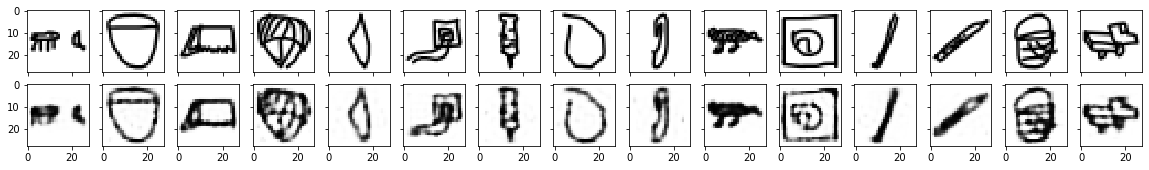

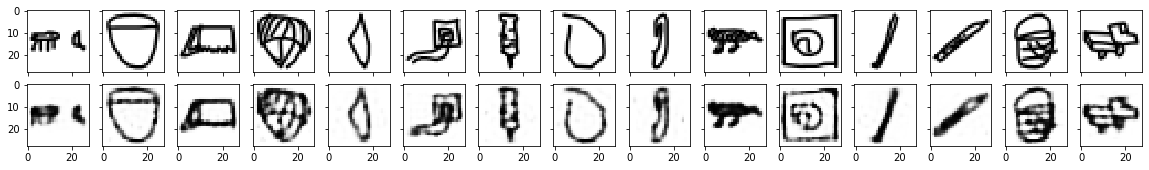

In [9]:
#Evaluation
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=15, 
                          shuffle=True)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
# =============================================================

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')
        
test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=15, 
                         shuffle=True)

# Checking the dataset
for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
# =============================================================

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')


#### K means

In [10]:
from sklearn.cluster import MiniBatchKMeans
import time
import pandas as pd
from collections import Counter
import ast

In [11]:
#Load data as input 
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=276000, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=69000, 
                          shuffle=False)

In [12]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

X_train = np.array(images.reshape(276000, 28*28))
y_train = np.array(labels)


for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

X_test = np.array(images.reshape(69000, 28*28))
y_test = np.array(labels)

Image batch dimensions: torch.Size([276000, 784])
Image label dimensions: torch.Size([276000])
Image batch dimensions: torch.Size([69000, 784])
Image label dimensions: torch.Size([69000])


In [13]:
#Concate to get the train and test dataset
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
print(X.shape)
print(y.shape)

(345000, 784)
(345000,)


In [14]:
#Get the string categories from dictionary mapping 
label_map = open(r"F:/Fall 2019/stat 479-ML/Project_Group_7/GITHUB/stat-479-project/DataPrep/label_map.txt")
label_map = ast.literal_eval(label_map.read())

y = list(y.flatten())
y = list(label_map.get(k, "") for k in y)

In [15]:
#Train K_means
prediction =[]
distortions = []
t0 = time.time()

for i in range(1, 345, 50):
    print(i)
    km = MiniBatchKMeans(init='k-means++', n_clusters=i, batch_size=10000, n_init=10, max_iter=300)
    prediction.append(km.fit_predict(X))
    distortions.append(km.inertia_)

    
km = MiniBatchKMeans(init='k-means++', n_clusters=345, batch_size=10000, n_init=10, max_iter=300)
prediction.append(km.fit_predict(X))
distortions.append(km.inertia_)
    
t_mini_batch = time.time() - t0

1
51
101
151
201
251
301


803.1193177700043


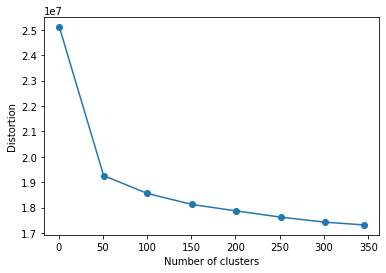

In [16]:
print(t_mini_batch)

plt.plot((1,51,100,151,201,251,301,345),distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [17]:
y_kmeans=list(prediction[5])
y_category = np.array(y)
clusters=set(y_kmeans)
print(clusters)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [18]:
cluster_index = []
for cluster in clusters:
    indices = [i for i, x in enumerate(y_kmeans) if x == cluster]
    cluster_index.append(indices)

In [19]:
category_cluster=[]
for index in cluster_index:
    category_cluster.append(y_category[index]) 

In [20]:
#Check the top 4 categories in each clusters
for new_category in category_cluster:
#     print(new_category)
    c = Counter(new_category)
    print(c.most_common(3))

[('envelope', 99), ('stereo', 72), ('couch', 72)]
[('sword', 73), ('flamingo', 63), ('golfclub', 58)]
[('houseplant', 141), ('TheEiffelTower', 120), ('snowman', 68)]
[('saw', 122), ('skateboard', 122), ('crocodile', 65)]
[('bandage', 81), ('baseballbat', 68), ('stairs', 62)]
[('hexagon', 155), ('octagon', 151), ('circle', 151)]
[('bowtie', 151), ('fireplace', 87), ('camera', 87)]
[('belt', 187), ('grass', 140), ('rifle', 103)]
[('teapot', 80), ('fish', 52), ('whale', 32)]
[('palmtree', 129), ('windmill', 117), ('flower', 86)]
[('calculator', 139), ('owl', 72), ('houseplant', 43)]
[('door', 158), ('remotecontrol', 116), ('skyscraper', 109)]
[('cat', 77), ('pig', 67), ('camel', 66)]
[('teddy-bear', 92), ('harp', 32), ('rabbit', 28)]
[('knee', 137), ('streetlight', 113), ('axe', 77)]
[('sheep', 103), ('cow', 76), ('rhinoceros', 66)]
[('square', 132), ('washingmachine', 132), ('dishwasher', 83)]
[('snail', 81), ('helicopter', 49), ('mosquito', 46)]
[('cannon', 91), ('fryingpan', 63), ('hor

In [36]:
#Check the top 4 categories in each clusters
top_categpry=[]
for new_category in category_cluster:
#     print(new_category)
    c = Counter(new_category)
    top_categpry.append(c.most_common(1))

In [39]:
print(top_categpry)

[[('envelope', 99)], [('sword', 73)], [('houseplant', 141)], [('saw', 122)], [('bandage', 81)], [('hexagon', 155)], [('bowtie', 151)], [('belt', 187)], [('teapot', 80)], [('palmtree', 129)], [('calculator', 139)], [('door', 158)], [('cat', 77)], [('teddy-bear', 92)], [('knee', 137)], [('sheep', 103)], [('square', 132)], [('snail', 81)], [('cannon', 91)], [('bus', 139)], [('necklace', 187)], [('purse', 95)], [('hedgehog', 91)], [('drill', 164)], [('shovel', 141)], [('tennisracquet', 75)], [('candle', 123)], [('hedgehog', 76)], [('bulldozer', 110)], [('barn', 69)], [('lipstick', 260)], [('lightbulb', 144)], [('camouflage', 65)], [('asparagus', 136)], [('eye', 76)], [('tennisracquet', 218)], [('mosquito', 51)], [('headphones', 138)], [('envelope', 134)], [('wineglass', 260)], [('underwear', 102)], [('fryingpan', 128)], [('golfclub', 172)], [('cellphone', 76)], [('stereo', 37)], [('donut', 76)], [('microwave', 94)], [('tornado', 65)], [('chair', 188)], [('scorpion', 63)], [('underwear', 14

In [42]:
print(top_categpry[1])

[('sword', 73)]


In [46]:
top_data=pd.read_excel(r"C:/Users/gaoru/Desktop/top_category.xlsx")

In [50]:
for i in range(top_data.shape[0]):
    array = str(top_data["Category"][i]).strip(" ").split(" ")
    top_data["Category"][i]=array [0]
    top_data["Number"][i]=array [1]

C:\Users\gaoru\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\gaoru\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [64]:
top_data.to_excel(r"C:/Users/gaoru/Desktop/top_category_.xlsx") 

In [71]:
top_data=pd.read_excel(r"C:/Users/gaoru/Desktop/top_category_.xlsx")
top_10_number=top_data["Number"][:11]#np.argpartition(top_data["Number"], -10)[-10:]
top_10_category = top_data["Category"][:11]#top_data["Category"][top_10_number]

print(top_10_number)
print(top_10_category)

0     538
1     467
2     432
3     411
4     344
5     288
6     288
7     280
8     274
9     263
10    261
Name: Number, dtype: int64
0      hourglass
1           line
2     headphones
3         bowtie
4            mug
5            sun
6           pear
7        rainbow
8        octagon
9       popsicle
10    winebottle
Name: Category, dtype: object


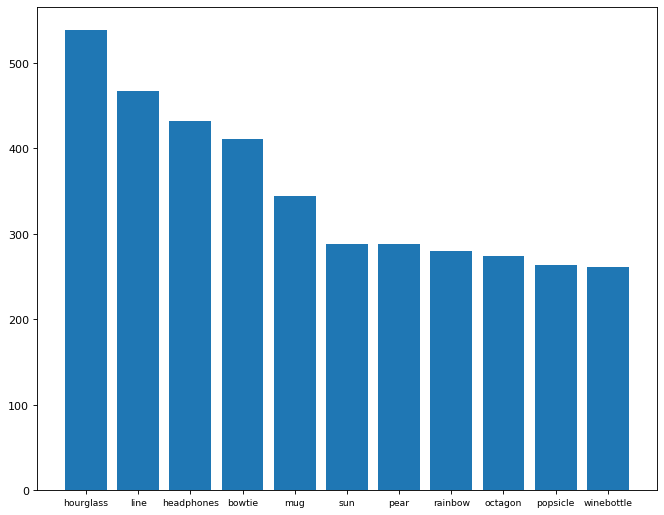

In [74]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

plt.bar(range(len(top_10_number)), top_10_number, align='center')
plt.xticks(range(len(top_10_category)), top_10_category, size='small')

plt.show()